# Восстановление золота из руды

# Постановка задачи

Заказчиком является инжиниринговая компания, которая разрабатывает решения для эффективной работы промышленных предприятий.

Требуется подготовить прототип модели машинного обучения, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

# Данные
В нашем распоряжении имеются данные с параметрами добычи и очистки.

Данные находятся в трёх файлах:

* **gold_recovery_train.csv** — обучающая выборка;
* **gold_recovery_test.csv** — тестовая выборка;
* **gold_recovery_full.csv** — исходные данные.

# Наименование признаков

Наименование признаков строится по следующему правилу:

[этап].[тип_параметра].[название_параметра]

Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:

* **rougher** — флотация
* **primary_cleaner** — первичная очистка
* **secondary_cleaner** — вторичная очистка
* **final** — финальные характеристики

Возможные значения для блока [тип_параметра]:

* **input** — параметры сырья
* **output** — параметры продукта
* **state** — параметры, характеризующие текущее состояние этапа
* **calculation** — расчётные характеристики

# План работы

0. Загрузка Библиотек
1. Подготовить данные
* 1.1. Проверим, что эффективность обогащения рассчитана правильно.
* 1.2. Проанализируем признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
* 1.3. Проведем предобработку данных.
* 1.4. Вывод По Подготовке данных.
2. Провести исследовательский анализ данных
* 2.1. Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.
* 2.2. Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.
* 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.
* 2.4. Вывод по анализу данных.
3. Построить и обучить модель
* 3.1. Подготовим датафреймы для прогнозирования features, target.
* 3.2. Напишите функцию для вычисления итоговой sMAPE.
* 3.3. Обучим разные модели и оценим их качество кросс-валидацией. Выберим лучшую модель и проверим её на тестовой выборке.
  * 3.3.1 Линейная регрессия.
  * 3.3.2. Дерево решений.
  * 3.3.3. Случайный лес.
* 3.4 Выберим лучшую модель и проверим её на тестовой выборке.
* 3.5. Проверка модели на адекватность.
* 3.6. Вывод по моделям.
4. Итоговый Вывод

# 0.Загрузка библиотек

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error 
import seaborn as sns
import numpy as np

# 1.Подготовка данных

In [2]:
try:
    data_full = pd.read_csv('gold_recovery_full_new.csv', index_col=['date'])
    data_test = pd.read_csv('gold_recovery_test_new.csv', index_col=['date'])
    data_train = pd.read_csv('gold_recovery_train_new.csv', index_col=['date'])
except:
    data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv', index_col=['date'])
    data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv', index_col=['date'])
    data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv', index_col=['date'])

In [3]:
# Рассмотрим наименования полей и типы данных.
data_train.info()
data_test.info()
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                             

In [4]:
data_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


In [5]:
data_full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


In [6]:
# Рассмотрим размер файлов.
data_train.shape, data_test.shape, data_full.shape

((14149, 86), (5290, 52), (19439, 86))

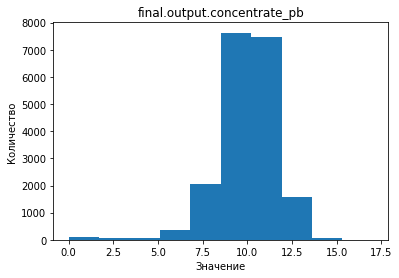

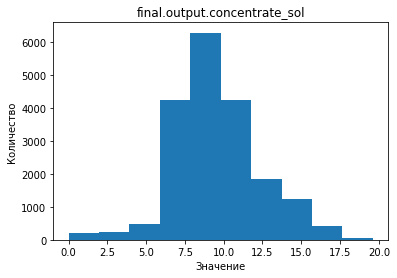

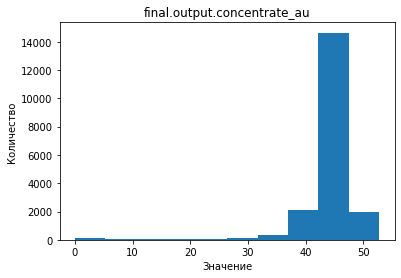

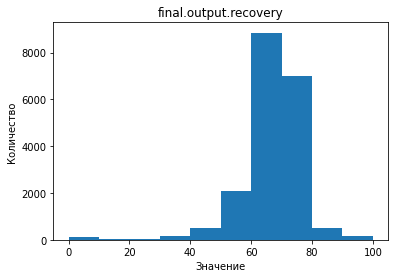

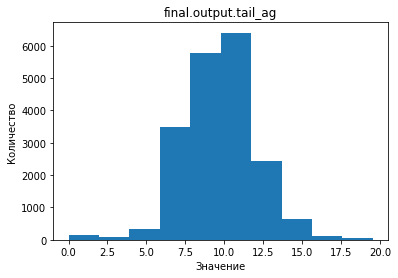

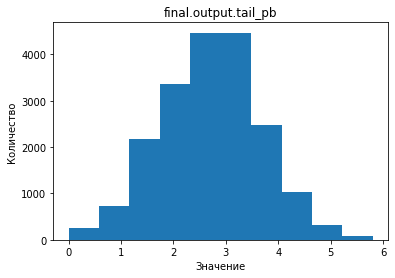

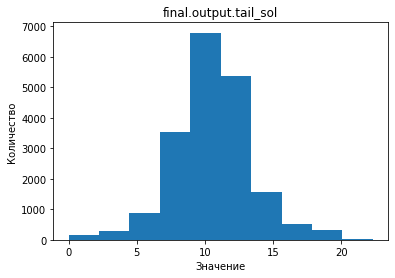

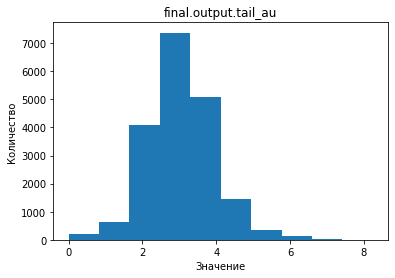

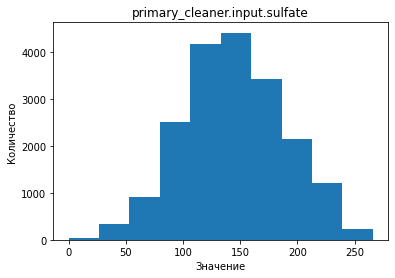

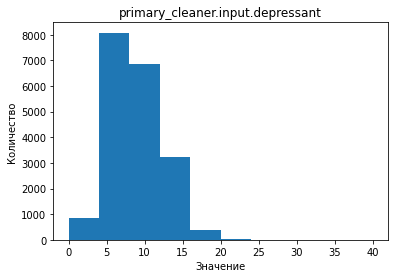

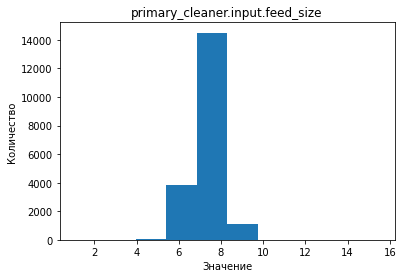

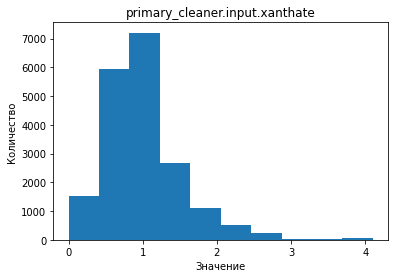

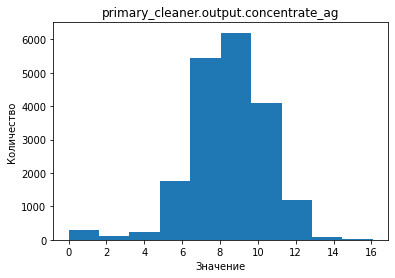

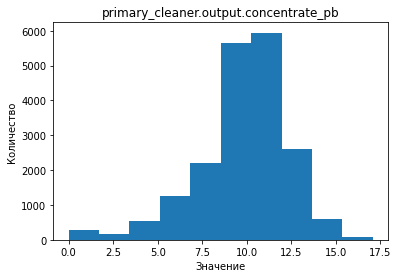

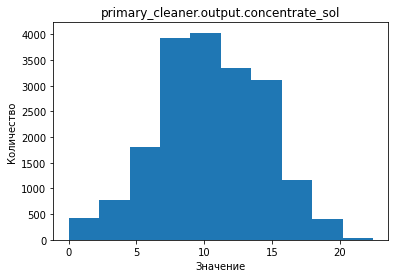

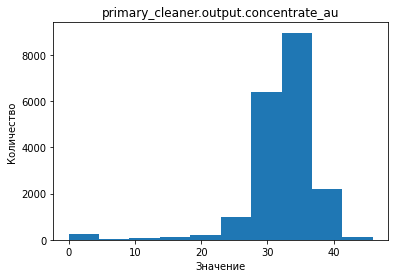

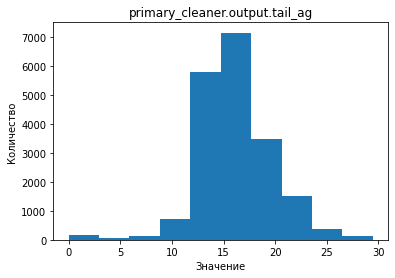

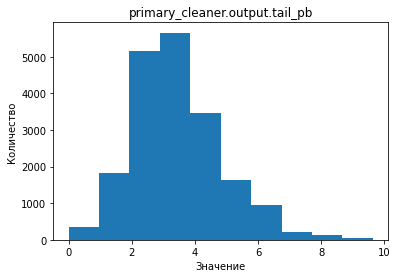

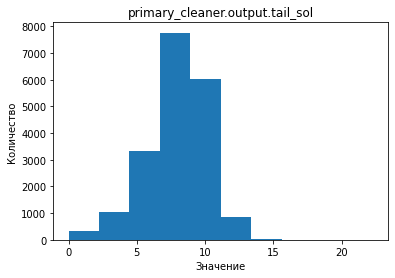

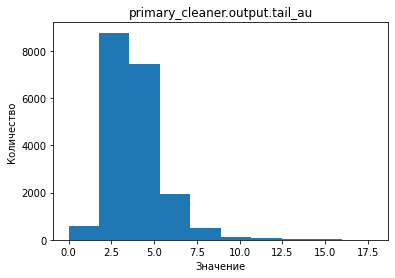

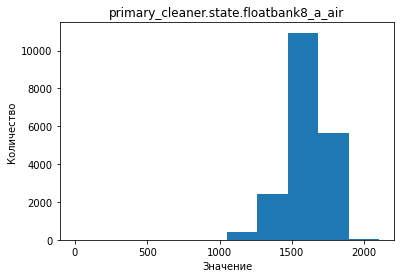

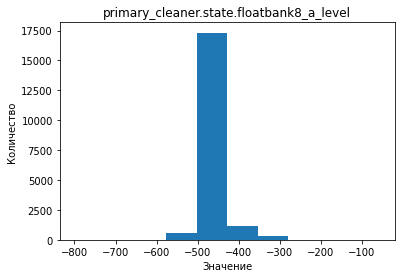

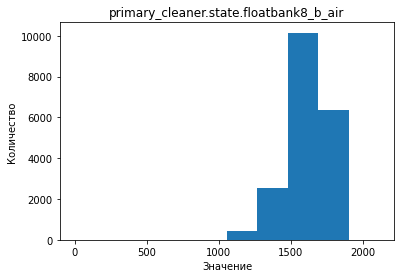

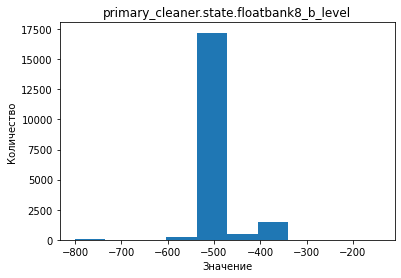

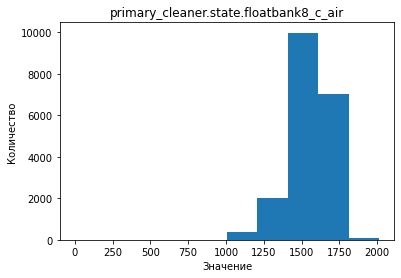

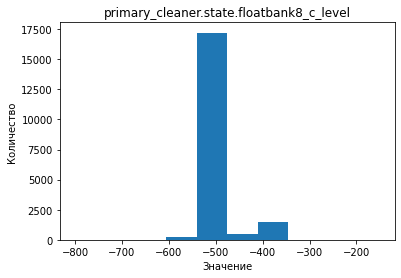

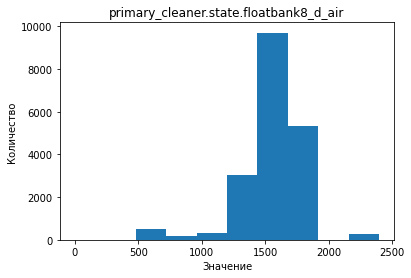

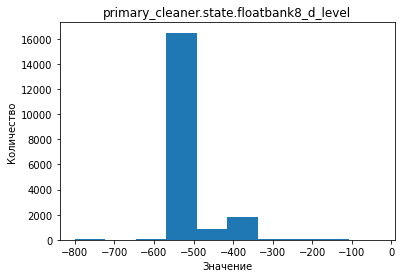

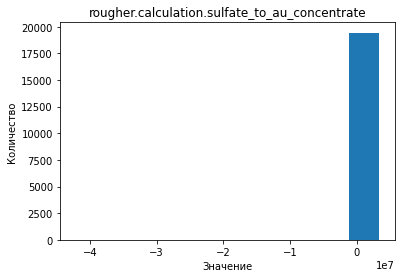

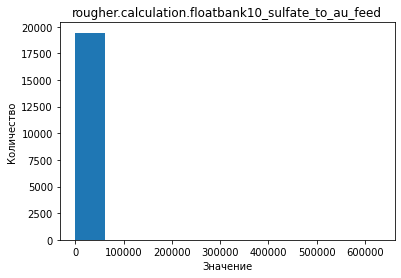

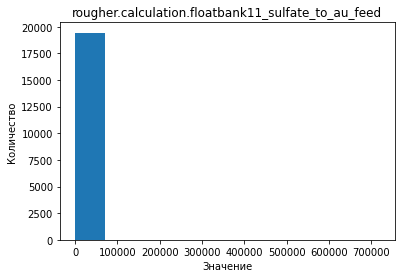

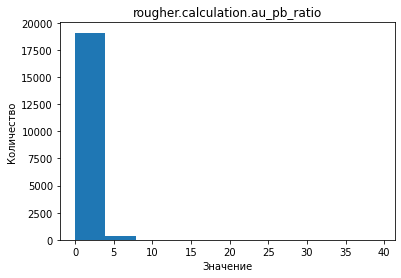

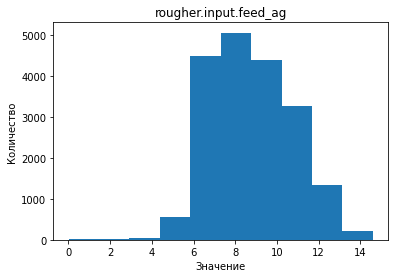

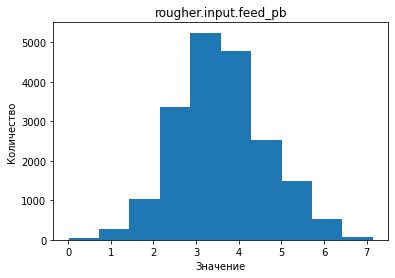

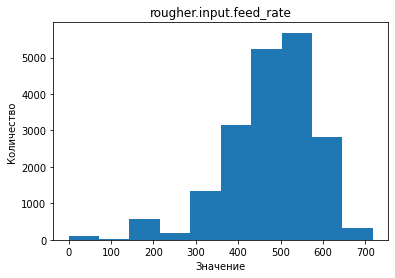

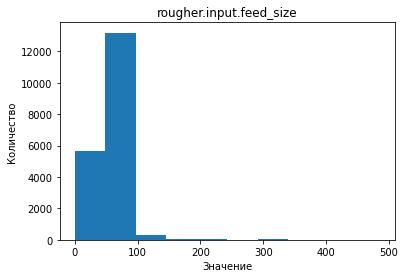

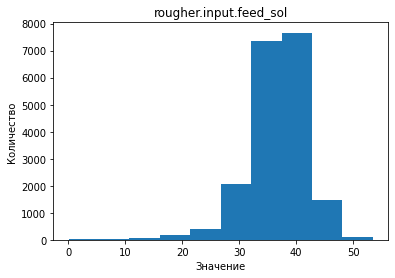

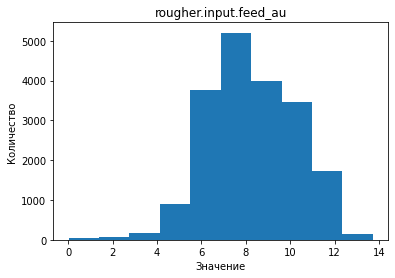

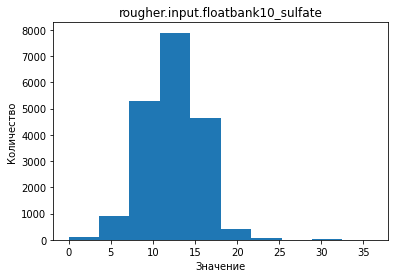

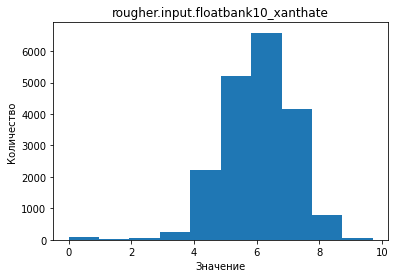

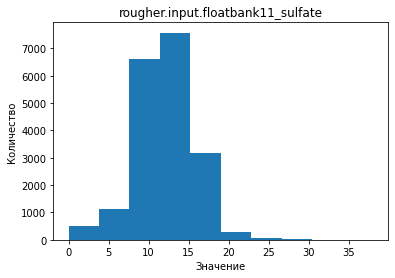

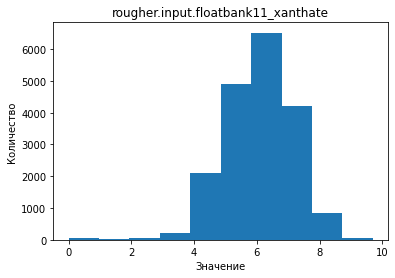

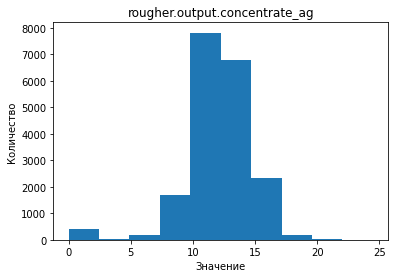

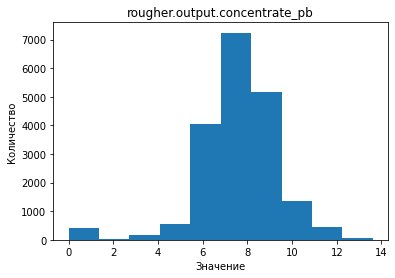

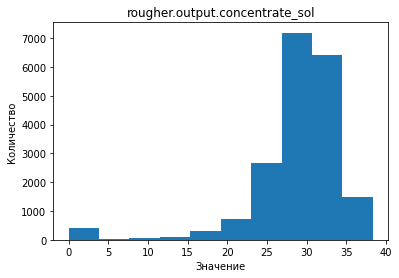

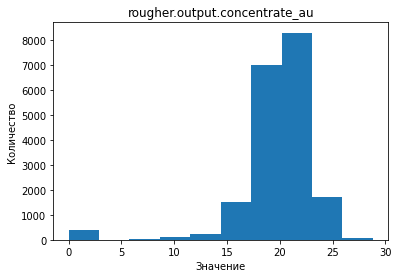

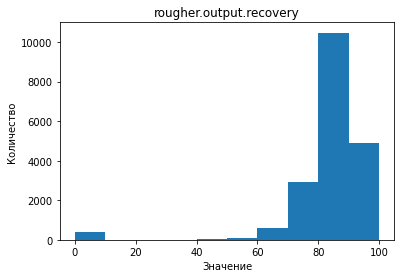

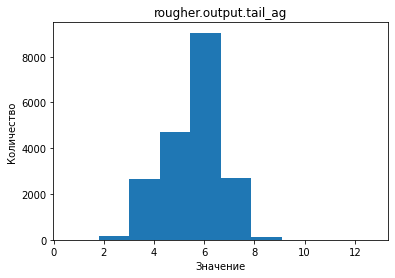

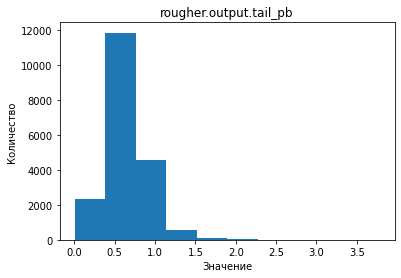

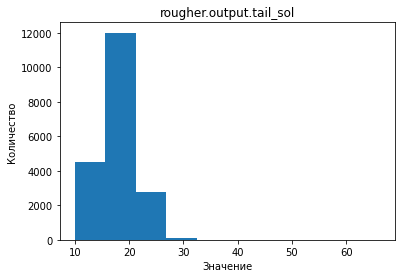

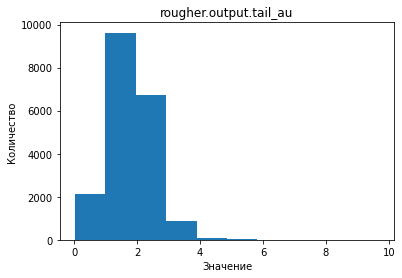

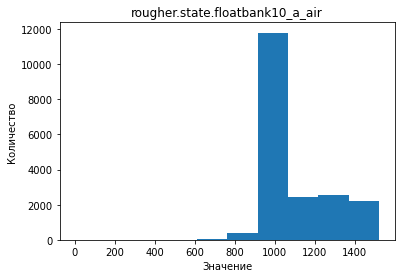

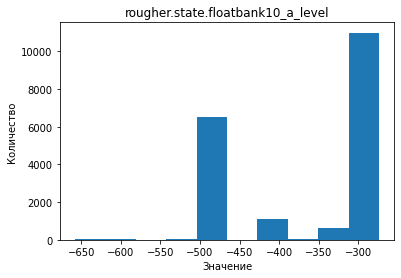

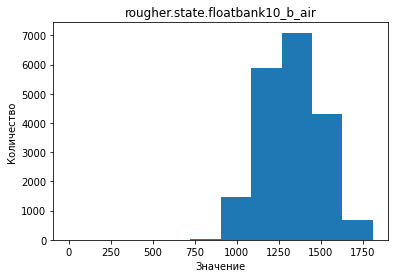

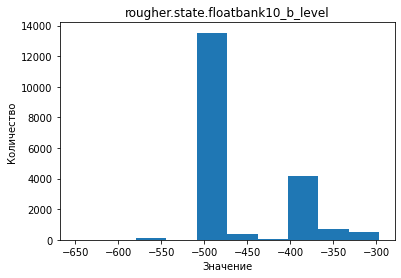

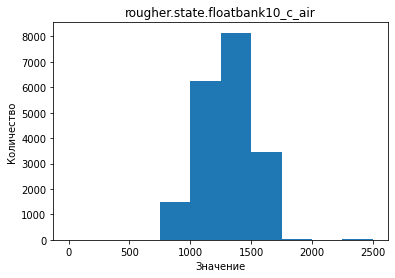

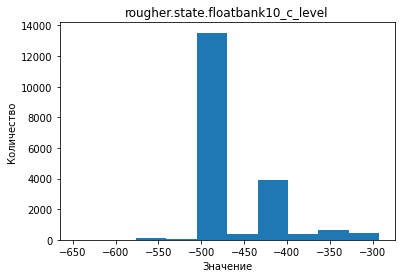

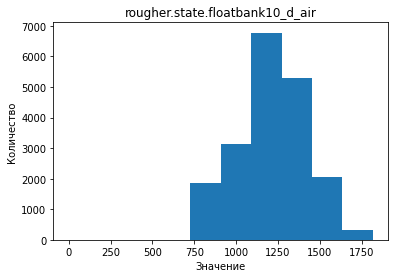

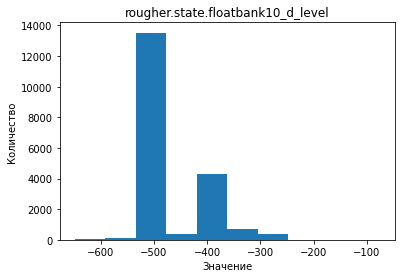

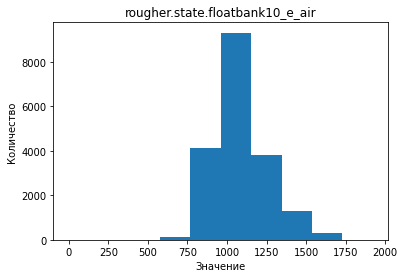

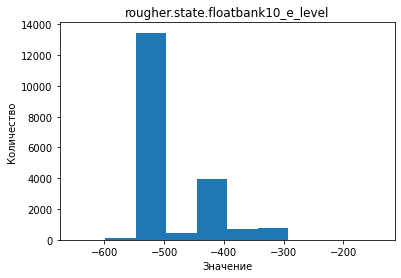

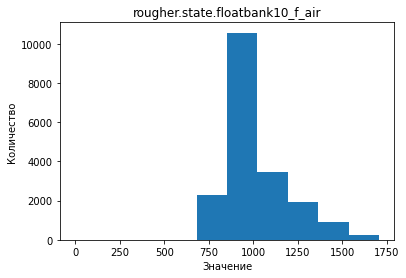

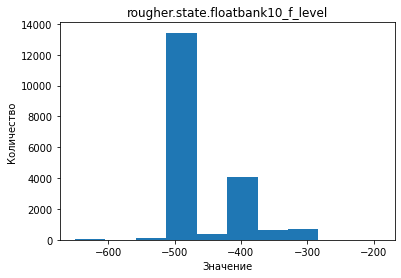

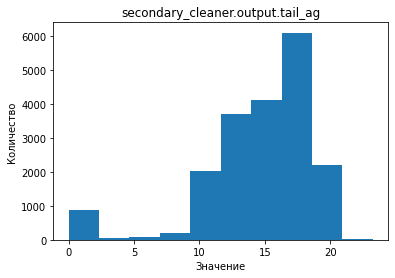

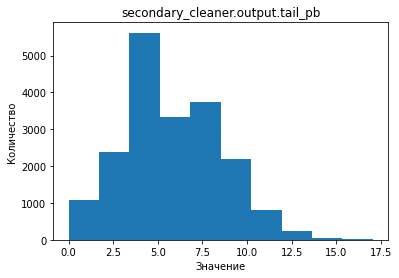

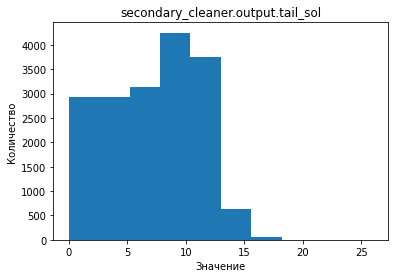

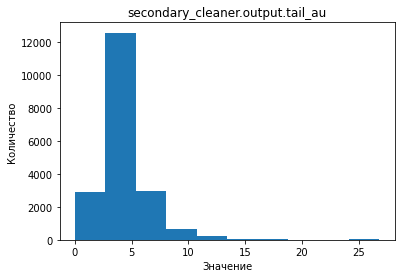

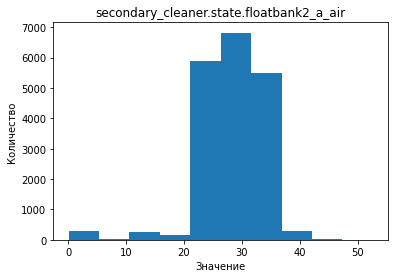

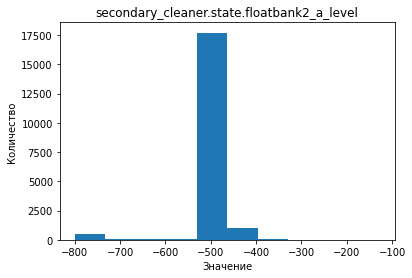

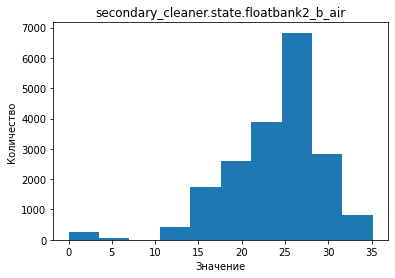

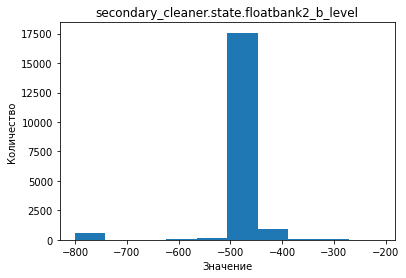

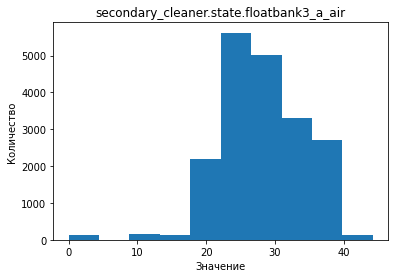

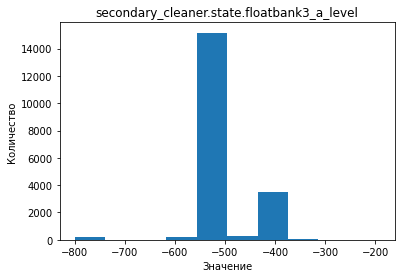

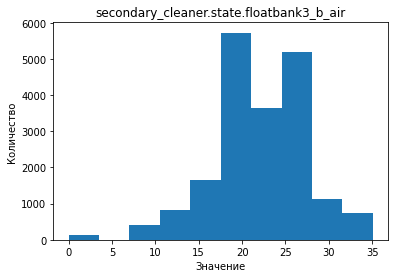

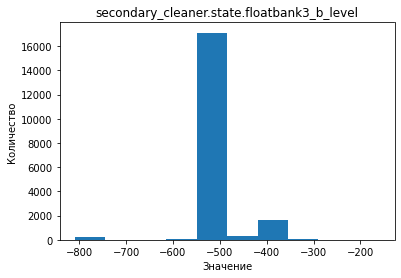

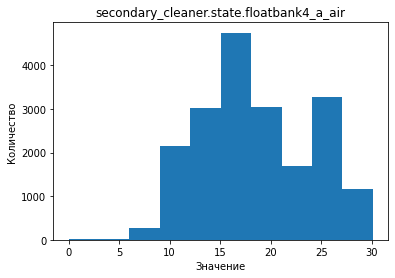

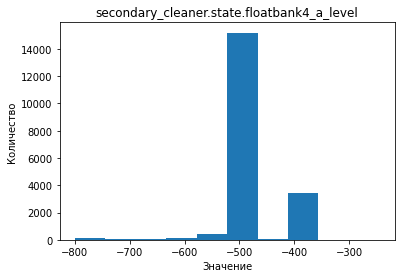

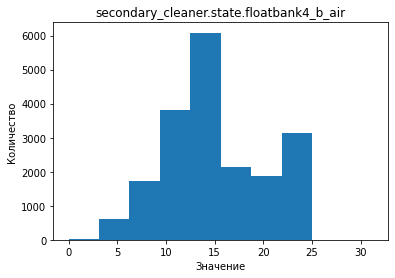

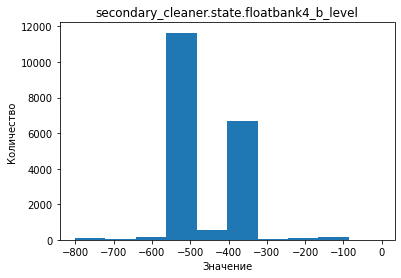

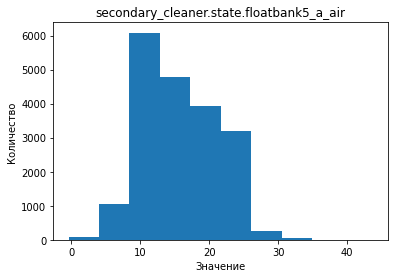

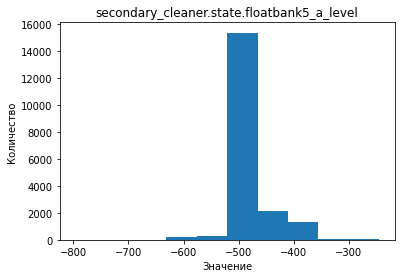

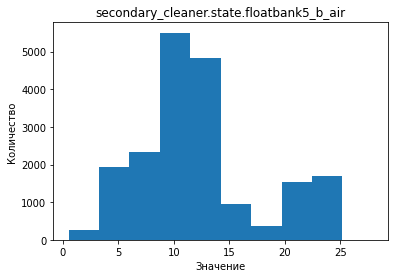

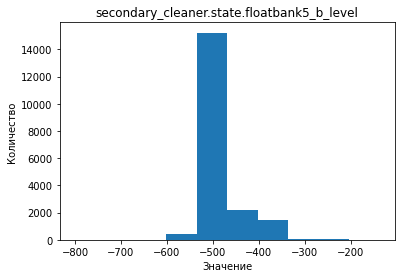

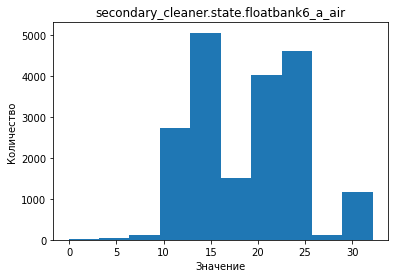

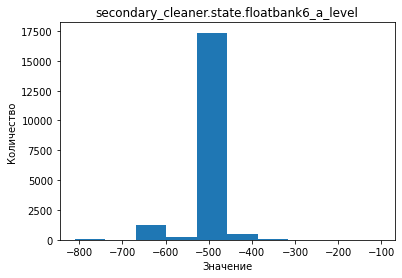

In [7]:
for column in data_full.columns[1:]:
    data = data_full[[column]]
    plt.hist(data)
    plt.title(column)
    plt.xlabel('Значение')
    plt.ylabel('Количество')
    plt.show()

**1.1. Проверим, что эффективность обогащения рассчитана правильно.**

In [8]:
data_train['recovery'] = (data_train['rougher.output.concentrate_au']*(data_train['rougher.input.feed_au'] - data_train['rougher.output.tail_au']))/(data_train['rougher.input.feed_au']*(data_train['rougher.output.concentrate_au'] - data_train['rougher.output.tail_au']))*100

In [9]:
data_train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,86.843261
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,86.842308
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,87.226430
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,86.688794


In [10]:
MАЕ_RECOVERY = mean_absolute_error(data_train['rougher.output.recovery'], data_train['recovery']) 
display('MАЕ_recovery равно:', MАЕ_RECOVERY)

'MАЕ_recovery равно:'

9.73512347450521e-15

**Вывод.**  Рассчитаные значения МАЕ близки к 0,эффективность обогащения рассчитана верно.

**1.2. Проанализируем признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?**

In [11]:
train_nottest = data_train.copy()

In [12]:
train_nottest = train_nottest.drop(columns=list(data_test.columns))

In [13]:
train_nottest.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 35 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                             

In [14]:
train_nottest.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.output.concentrate_ag,...,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,8.547551,...,87.107763,5.008018,0.508728,19.154297,1.170244,14.500184,4.694824,8.764648,2.606185,87.107763
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,8.558743,...,86.843261,4.955378,0.536689,18.965234,1.184827,14.265474,4.592547,9.001494,2.488248,86.843261
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,8.603505,...,86.842308,4.843460,0.546416,18.808533,1.162562,14.115662,4.624775,8.842896,2.458187,86.842308
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,7.221879,...,87.226430,4.655288,0.542525,19.330200,1.079755,13.732071,4.482453,9.122857,2.322062,87.226430
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,9.089428,...,86.688794,4.552800,0.515438,19.267422,1.012642,14.079996,4.470737,8.871028,2.330448,86.688794


**Вывод.**
Проанализировав признаки, недоступные в тестовой выборке мы пришли к выводу что причиной их стало отсутвие таких признаков как:

* Целевые признаки **rougher.output.recovery** и **final.output.recovery.**

* Значения **output** по всем операциям и по всем элементам.Это данные которые возможно получить только при реальных  измерениях.

Но так как тестовая выборка похожа на реальные данные ,то недостающие параметры не должны быть в ней.

Для проверки качества моделей мы используем **rougher.output.recovery** и **final.output.recovery.** для получения выборки.

In [15]:
data_train.duplicated().sum()

0

In [16]:
data_test.duplicated().sum()

0

In [17]:
data_full.duplicated().sum()

0

**Вывод.** Дубликатов не обнаружено, можно добавлять данные и работать с ними.

In [18]:
# Добавим недостающие данные в data_test
data_test = data_test.merge(data_full[['final.output.recovery', 'rougher.output.recovery']], how ='left', on='date')

**1.3. Проведем предобработку данных.**

In [19]:
# Посчитаем общее количество пропусков
display(data_full.isna().sum())

final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
final.output.recovery                           0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 86, dtype: int64

In [20]:
# Заполним пропуски.
data_full = data_full.fillna(method='ffill')
data_train = data_train.fillna(method='ffill')
data_test = data_test.fillna(method='ffill')

In [21]:
# проверим количесто оставшихся пропусков
display('Количество строк с пропусками в data_train', data_train.isna().sum().sum())
display('Количество строк с пропусками в data_test', data_test.isna().sum().sum())
display('Количество строк с пропусками в data_full', data_full.isna().sum().sum())

'Количество строк с пропусками в data_train'

0

'Количество строк с пропусками в data_test'

0

'Количество строк с пропусками в data_full'

0

**1.4. Вывод По Подготовке данных.** 

В данном разделе открыты файлы и изучены основные данные:

* Построены графика распределения значений по всем числовым полям. Большинство признаков имеют нормальное распределение, но вместе с тем встречаются и скошенные распределения. Также у некоторых признаков видно значимое число значений в области нуля. Вероятно это выбросы. В дальнейшем анализе нужно обратить на них внимание.


* Рассчитаные значения МАЕ близки к 0,эффективность обогащения рассчитана верно.Проанализированы поля недоступные в тестовой выборке, где отсутствуют целевые признаки для моделей 'rougher.output.recovery', 'final.output.recovery', а также значения output по всем операциям по всем элементам. 


* Проведена проверка на дубликаты. Обработаны пропуски.


* Исключительно для проверки качества оценки модели поля 'rougher.output.recovery', 'final.output.recovery' добавлены в тестовый файл для формирования выборки target_test.

# 2. Анализ данных

**2.1. Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.**

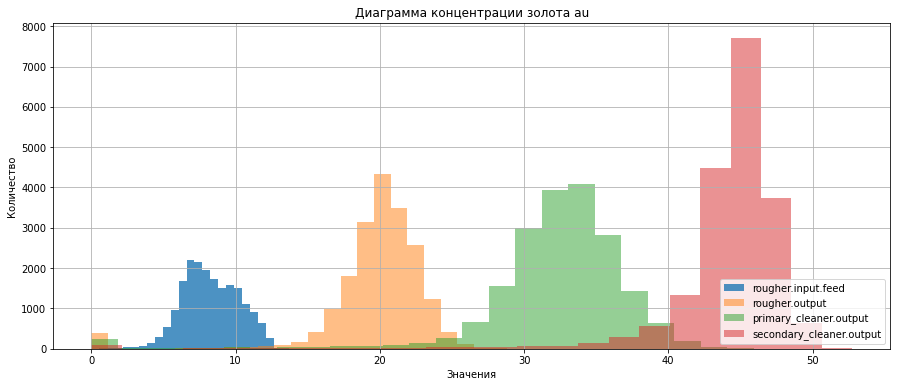

In [22]:
# Построим Диаграмму концентрации золота Au.
plt.figure(figsize=(15,6))
data_full['rougher.input.feed_au'].hist(bins=25, label='rougher.input.feed', alpha=0.8)
data_full['rougher.output.concentrate_au'].hist(bins=25, label='rougher.output', alpha=0.5)
data_full['primary_cleaner.output.concentrate_au'].hist(bins=25, label='primary_cleaner.output', alpha=0.5)
data_full['final.output.concentrate_au'].hist(bins=25, label='secondary_cleaner.output', alpha=0.5)

plt.title('Диаграмма концентрации золота au')
plt.xlabel('Значения')
plt.ylabel('Количество')
plt.legend(loc='lower right')
plt.show()

In [23]:
 round(data_full[['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']].mean(),1)

rougher.output.concentrate_au            19.8
primary_cleaner.output.concentrate_au    32.1
final.output.concentrate_au              44.1
dtype: float64

In [24]:
round(data_full[['rougher.output.tail_au', 'primary_cleaner.output.tail_au', 'secondary_cleaner.output.tail_au']].mean(),1)

rougher.output.tail_au              1.8
primary_cleaner.output.tail_au      3.9
secondary_cleaner.output.tail_au    4.3
dtype: float64

**Вывод.** Концентрация золота значительно увеличивается на каждом этапе обработки сырья.

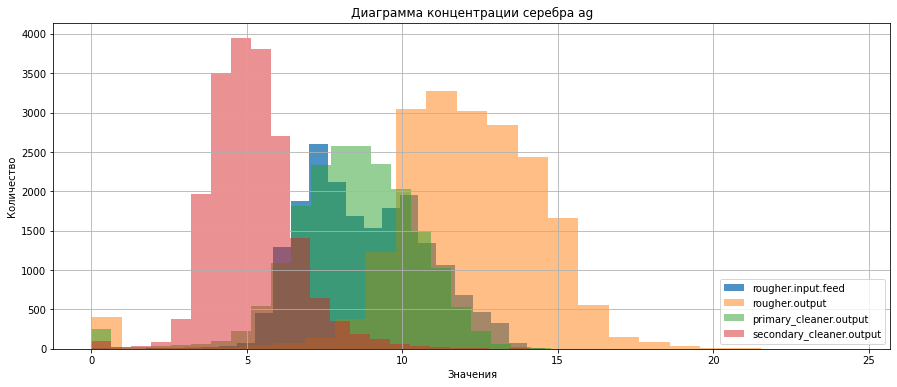

In [25]:
# Построим Диаграмму концентрации серебра Ag
plt.figure(figsize=(15,6))
data_full['rougher.input.feed_ag'].hist(bins=25, label='rougher.input.feed', alpha=0.8)
data_full['rougher.output.concentrate_ag'].hist(bins=25, label='rougher.output', alpha=0.5)
data_full['primary_cleaner.output.concentrate_ag'].hist(bins=25, label='primary_cleaner.output', alpha=0.5)
data_full['final.output.concentrate_ag'].hist(bins=25, label='secondary_cleaner.output', alpha=0.5)

plt.title('Диаграмма концентрации серебра ag')
plt.legend(loc='lower right')
plt.xlabel('Значения')
plt.ylabel('Количество')
plt.show()

In [26]:
round(data_full[['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']].mean(),1)

rougher.output.concentrate_ag            12.0
primary_cleaner.output.concentrate_ag     8.4
final.output.concentrate_ag               5.2
dtype: float64

In [27]:
round(data_full[['rougher.output.tail_ag', 'primary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_ag']].mean(),1)

rougher.output.tail_ag               5.6
primary_cleaner.output.tail_ag      16.1
secondary_cleaner.output.tail_ag    14.6
dtype: float64

**Вывод.**  После первого этапа очистки концентрация серебра уменьшается, после второго ещё уменьшается.

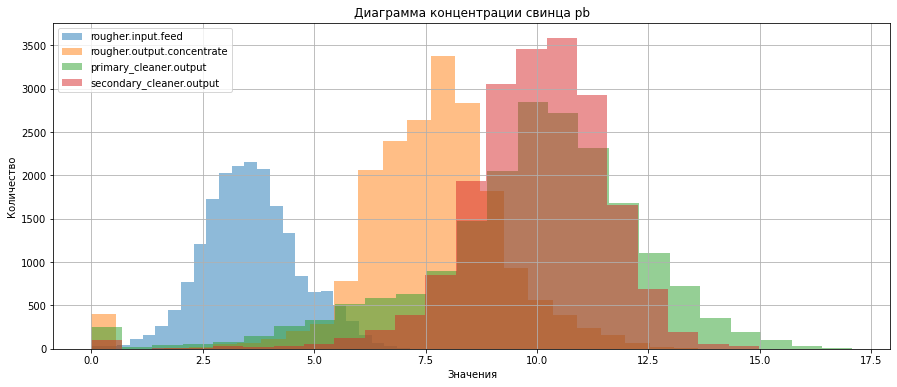

In [28]:
# Построим Диаграмму концентрации свинца Pb
plt.figure(figsize=(15,6))

data_full['rougher.input.feed_pb'].hist(bins=25, label='rougher.input.feed', alpha=0.5)
data_full['rougher.output.concentrate_pb'].hist(bins=25, label='rougher.output.concentrate', alpha=0.5)
data_full['primary_cleaner.output.concentrate_pb'].hist(bins=25, label='primary_cleaner.output', alpha=0.5)
data_full['final.output.concentrate_pb'].hist(bins=25, label='secondary_cleaner.output', alpha=0.5)
plt.title('Диаграмма концентрации свинца pb')

plt.legend(loc='upper left')
plt.xlabel('Значения')
plt.ylabel('Количество')
plt.show()

In [29]:
round(data_full[['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']].mean(),1)

rougher.output.concentrate_pb             7.6
primary_cleaner.output.concentrate_pb     9.8
final.output.concentrate_pb              10.0
dtype: float64

In [30]:
round(data_full[['rougher.output.tail_pb', 'primary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_pb']].mean()
,1)

rougher.output.tail_pb              0.6
primary_cleaner.output.tail_pb      3.4
secondary_cleaner.output.tail_pb    5.8
dtype: float64

**Вывод.** После первого этапа очистки концентрация свинца увеличивается, после второго этапа очистки остаётся примерно на этом же уровне. 

**2.2. Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.**

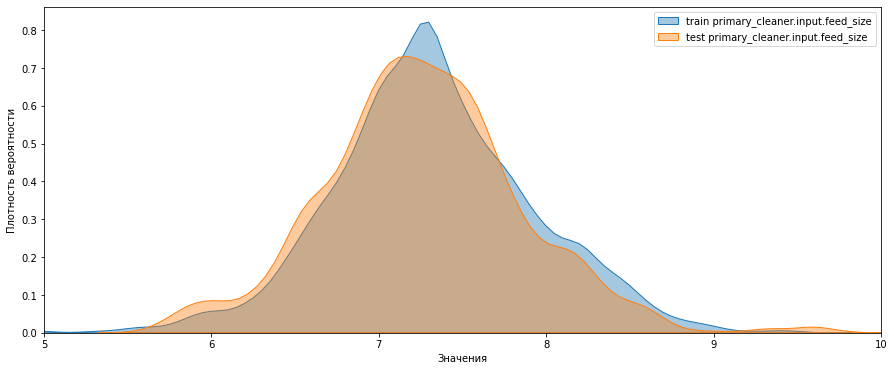

count    14149.000000
mean         7.322310
std          0.614062
min          1.080000
25%          6.960000
50%          7.290000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64

count    5290.000000
mean        7.266339
std         0.610219
min         5.650000
25%         6.890000
50%         7.250000
75%         7.600000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64

In [31]:
# Построим Диаграмму концентрации размера сырья.
plt.figure(figsize=(15,6))
sns.kdeplot(data_train['primary_cleaner.input.feed_size'], 
         label='train primary_cleaner.input.feed_size', alpha=0.4, shade=True)
sns.kdeplot(data_test['primary_cleaner.input.feed_size'],  
         label='test primary_cleaner.input.feed_size', alpha=0.4, shade=True)
plt.xlim([5, 10])
plt.xlabel('Значения')
plt.ylabel('Плотность вероятности')
plt.legend(loc='upper right')
plt.show()

display(data_train['primary_cleaner.input.feed_size'].describe())
display(data_test['primary_cleaner.input.feed_size'].describe())

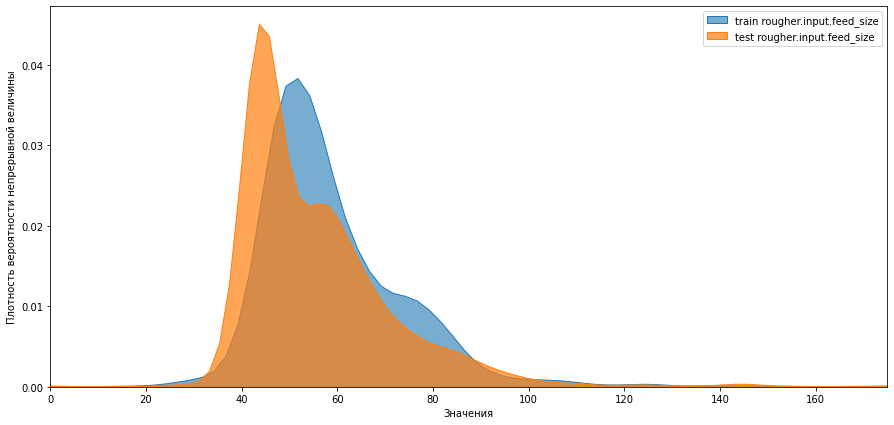

count    14149.0
mean        60.0
std         23.0
min         10.0
25%         49.0
50%         55.0
75%         66.0
max        485.0
Name: rougher.input.feed_size, dtype: float64

count    5290.0
mean       56.0
std        19.0
min         0.0
25%        44.0
50%        51.0
75%        62.0
max       392.0
Name: rougher.input.feed_size, dtype: float64

In [32]:
# Построим Диаграмму концентрации размера сырья на входе флотации train и test
plt.figure(figsize=(15,7))
sns.kdeplot(data_train['rougher.input.feed_size'], label='train rougher.input.feed_size', alpha=0.6, shade=True)
sns.kdeplot(data_test['rougher.input.feed_size'], label='test rougher.input.feed_size', alpha=0.7, shade=True)

plt.xlim([0, 175])
plt.xlabel('Значения')
plt.ylabel('Плотность вероятности непрерывной величины')
plt.legend(loc='upper right')
plt.show()

display(round(data_train['rougher.input.feed_size'].describe()))
display(round(data_test['rougher.input.feed_size'].describe()))

**2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.** 

In [33]:
# Суммарная концентрация на выходе флотации.
data_full['rougher.output.concentrate_au_ag_pb_sol'] = \
                data_full['rougher.output.concentrate_au']\
              + data_full['rougher.output.concentrate_ag']\
              + data_full['rougher.output.concentrate_pb']\
              + data_full['rougher.output.concentrate_sol']

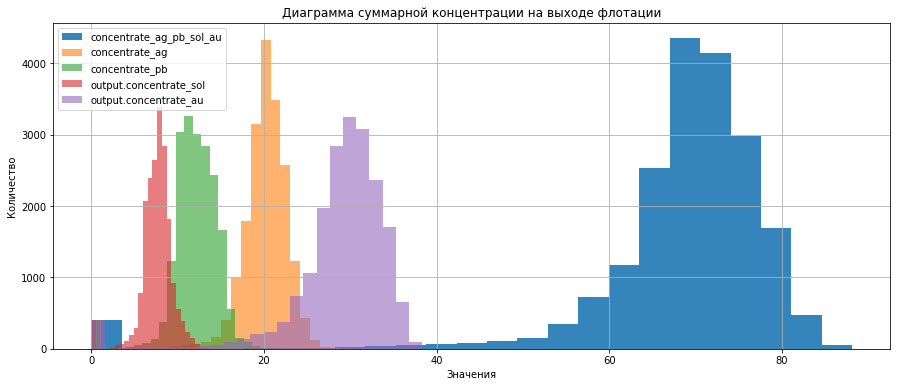

In [34]:
# Построим Диаграмму суммарной концентрации на выходе флотации
plt.figure(figsize=(15,6))
data_full['rougher.output.concentrate_au_ag_pb_sol'].hist(bins=25, label='concentrate_ag_pb_sol_au', alpha=0.9)
data_full['rougher.output.concentrate_au'].hist(bins=25, label='concentrate_ag', alpha=0.6)
data_full['rougher.output.concentrate_ag'].hist(bins=25, label='concentrate_pb', alpha=0.6)
data_full['rougher.output.concentrate_pb'].hist(bins=25, label='output.concentrate_sol', alpha=0.6)
data_full['rougher.output.concentrate_sol'].hist(bins=25, label='output.concentrate_au', alpha=0.6)

plt.title('Диаграмма суммарной концентрации на выходе флотации')
plt.xlabel('Значения')
plt.ylabel('Количество')
plt.legend(loc='upper left')
plt.show()

**Выход.** Как видим на диаграмме есть выбросы при значениях суммарной концентрации = 0

In [35]:
# суммарная концентрация на выходе первой очистки
data_full['primary_cleaner.output.concentrate_au_ag_pb_sol'] = \
                data_full['primary_cleaner.output.concentrate_au']\
              + data_full['primary_cleaner.output.concentrate_ag']\
              + data_full['primary_cleaner.output.concentrate_pb']\
              + data_full['primary_cleaner.output.concentrate_sol']

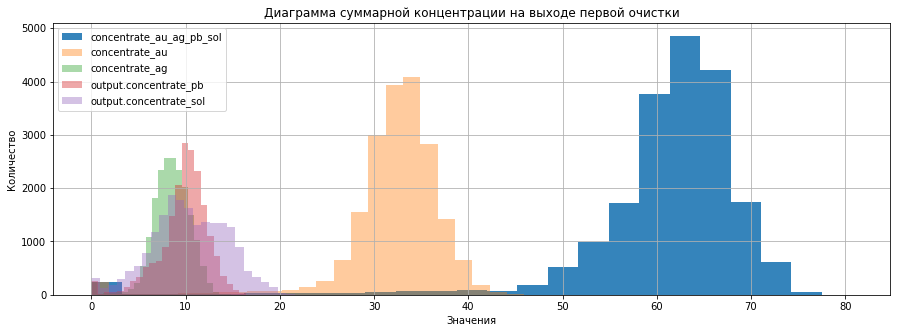

In [36]:
# Диаграмма суммарной концентрации на выходе первой очистки
plt.figure(figsize=(15,5))
data_full['primary_cleaner.output.concentrate_au_ag_pb_sol'].hist(bins=25, label='concentrate_au_ag_pb_sol', alpha=0.9)
data_full['primary_cleaner.output.concentrate_au'].hist(bins=25, label='concentrate_au', alpha=0.4)
data_full['primary_cleaner.output.concentrate_ag'].hist(bins=25, label='concentrate_ag', alpha=0.4)
data_full['primary_cleaner.output.concentrate_pb'].hist(bins=25, label='output.concentrate_pb', alpha=0.4)
data_full['primary_cleaner.output.concentrate_sol'].hist(bins=25, label='output.concentrate_sol', alpha=0.4)

plt.title('Диаграмма суммарной концентрации на выходе первой очистки')
plt.xlabel('Значения')
plt.ylabel('Количество')
plt.legend(loc='upper left')
plt.show()

**Выход.** Как видим на диаграмме есть выбросы при значениях суммарной концентрации = 0

In [37]:
# Построим функцию метода расчёта суммарных концентраций на всех этапах
def sum_concentrated(df):
    
    # суммарная концентрация исходного сырья для флотации.
    df['rougher.input.feed_au_ag_pb_sol'] = \
                df['rougher.input.feed_au']\
              + df['rougher.input.feed_ag']\
              + df['rougher.input.feed_pb']\
              + df['rougher.input.feed_sol']
    
    
    # суммарная концентрация на выходе флотации
    df['rougher.output.concentrate_au_ag_pb_sol'] = \
                df['rougher.output.concentrate_au']\
              + df['rougher.output.concentrate_ag']\
              + df['rougher.output.concentrate_pb']\
              + df['rougher.output.concentrate_sol']
    
    # суммарная концентрация на выходе первой очистки
    df['primary_cleaner.output.concentrate_au_ag_pb_sol'] = \
                df['primary_cleaner.output.concentrate_au']\
              + df['primary_cleaner.output.concentrate_ag']\
              + df['primary_cleaner.output.concentrate_pb']\
              + df['primary_cleaner.output.concentrate_sol']
    
    # суммарная концентрация на выходе финальной очистки
    df['final.output.concentrate_au_ag_pb_sol'] = \
                df['final.output.concentrate_au']\
              + df['final.output.concentrate_ag']\
              + df['final.output.concentrate_pb']\
              + df['final.output.concentrate_sol']
    return df

In [38]:
data_full['rougher.input.feed_au_ag_pb_sol'] = \
                data_full['rougher.input.feed_au']\
              + data_full['rougher.input.feed_ag']\
              + data_full['rougher.input.feed_pb']\
              + data_full['rougher.input.feed_sol']

In [39]:
data_full['final.output.concentrate_au_ag_pb_sol'] = \
                data_full['final.output.concentrate_au']\
              + data_full['final.output.concentrate_ag']\
              + data_full['final.output.concentrate_pb']\
              + data_full['final.output.concentrate_sol']

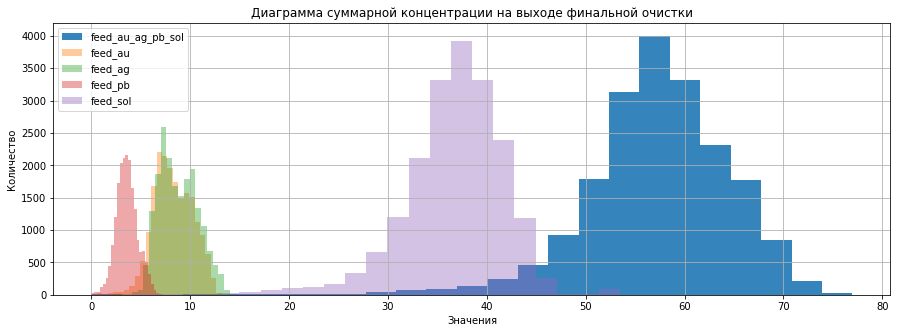

In [40]:
# Построим Диаграмму суммарной концентрации исходного сырья для финальной очистки
plt.figure(figsize=(15,5))
data_full['rougher.input.feed_au_ag_pb_sol'].hist(bins=25, label='feed_au_ag_pb_sol', alpha=0.9)
data_full['rougher.input.feed_au'].hist(bins=25, label='feed_au', alpha=0.4)
data_full['rougher.input.feed_ag'].hist(bins=25, label='feed_ag', alpha=0.4)
data_full['rougher.input.feed_pb'].hist(bins=25, label='feed_pb', alpha=0.4)
data_full['rougher.input.feed_sol'].hist(bins=25, label='feed_sol', alpha=0.4)

plt.title('Диаграмма суммарной концентрации на выходе финальной очистки')
plt.xlabel('Значения')
plt.ylabel('Количество')
plt.legend(loc='upper left')
plt.show()

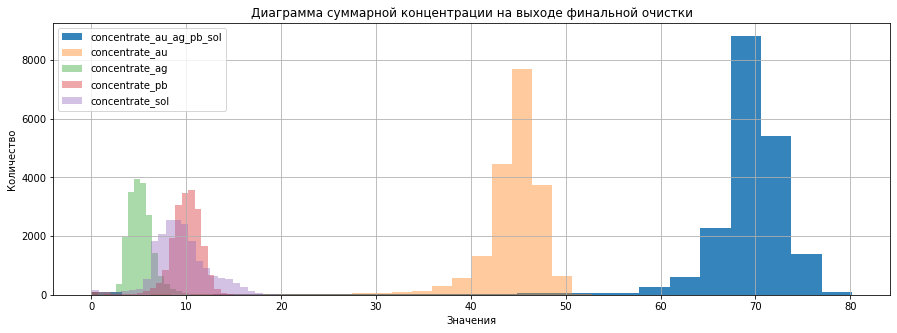

In [41]:
# Построим Диаграмму суммарной концентрации на выходе финальной очистки
plt.figure(figsize=(15,5))
data_full['final.output.concentrate_au_ag_pb_sol'].hist(bins=25, label='concentrate_au_ag_pb_sol', alpha=0.9)
data_full['final.output.concentrate_au'].hist(bins=25, label='concentrate_au', alpha=0.4)
data_full['final.output.concentrate_ag'].hist(bins=25, label='concentrate_ag', alpha=0.4)
data_full['final.output.concentrate_pb'].hist(bins=25, label='concentrate_pb', alpha=0.4)
data_full['final.output.concentrate_sol'].hist(bins=25, label='concentrate_sol', alpha=0.4)

plt.title('Диаграмма суммарной концентрации на выходе финальной очистки')
plt.xlabel('Значения')
plt.ylabel('Количество')
plt.legend(loc='upper left')
plt.show()

**Вывод.** Бросаются в глаза аномальные нулевые значения и суммарные значения на каждом этапе. Считаю необходимым удалить значения из train

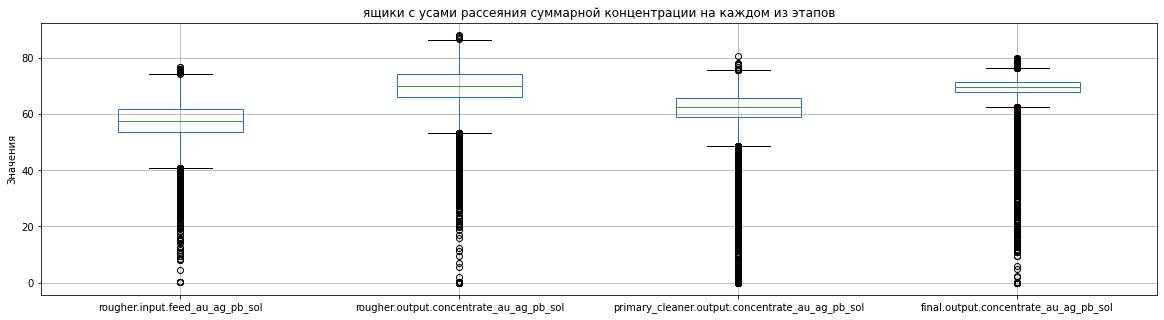

In [42]:
# Ящик с усами рассеяния суммарной концентрации на каждом из этапов
data_full[['rougher.input.feed_au_ag_pb_sol', 'rougher.output.concentrate_au_ag_pb_sol', 'primary_cleaner.output.concentrate_au_ag_pb_sol', 'final.output.concentrate_au_ag_pb_sol']].\
boxplot(figsize = (20,5))
plt.title('ящики с усами рассеяния суммарной концентрации на каждом из этапов')
plt.ylabel('Значения')
plt.show()

**Вывод.** На графике явно видно наличие выбросов в нуле и малых значениях по всем суммарный значениям концентрации веществ на разных стадиях тчистки. Но удалять в качестве выбросов считаю необходимым только нулевые, так как причиной  нулевого значения суммарной концентрации веществ может являться сбой оборудования, а малые значения могут в реальности быть.

In [43]:
# Сделаем новую выборку без выбросов.
data_full_emission_free = \
data_full[(data_full['rougher.input.feed_au_ag_pb_sol'] > 0)
         &(data_full['rougher.output.concentrate_au_ag_pb_sol']> 0 )
         &(data_full['primary_cleaner.output.concentrate_au_ag_pb_sol'] > 0)
         &(data_full['final.output.concentrate_au_ag_pb_sol'] > 0 )]
data_full_emission_free.shape

(18848, 90)

In [44]:
# Подготовим суммарные концентрации на этапах очистки для train
data_train = sum_concentrated(data_train)

In [45]:
# Сделаем новую выборку без выбросов для переменной data_train
data_train_emission_free = \
data_train[(data_full['rougher.input.feed_au_ag_pb_sol'] > 0)
         &(data_train['rougher.output.concentrate_au_ag_pb_sol'] > 0)
         &(data_train['primary_cleaner.output.concentrate_au_ag_pb_sol'] > 0)
         &(data_train['final.output.concentrate_au_ag_pb_sol'] > 0)]
data_train_emission_free.shape

/tmp/ipykernel_245/2025720092.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_train[(data_full['rougher.input.feed_au_ag_pb_sol'] > 0)


(13725, 91)

**2.4. Вывод по анализу данных.**

* Анализ концентрации металлов показал, что концентрация золота значительно увеличивается на каждом этапе обработки сырья. Концентрация золота в отвалах тоже увеличивается, но при этом на порядок ниже чем в сырье. На всех графиках концентрации сырья видны значения равные нулю. Судя по распределению, это выбросы.

* Построены графики распределения плотности вероятности значений размеров гранул на входе в этапы флотации и финальной очистки выборок train и test Сами распределения похожи, что говорит об однородности данных размеров сырья в выборках train и test

# 3. Модель

**3.1. Подготовим датафреймы для прогнозирования features, target.**

In [46]:
# список признаков для обучения модели
features_columns = list(data_test.columns)[1:-2]

In [47]:
# список целевых признаков
target_columns = list(reversed(list(data_test.columns)[-2:]))

In [48]:
display('Количество значений в target_columns:', len(target_columns)) 

display('Список значений target_columns:') 

display(target_columns) 

display('Количество значений в features_columns:', len(features_columns)) 

display(' Список значений features_columns:') 

display(features_columns)

'Количество значений в target_columns:'

2

'Список значений target_columns:'

['rougher.output.recovery', 'final.output.recovery']

'Количество значений в features_columns:'

51

' Список значений features_columns:'

['primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'r

In [49]:
# формируем необходимые для обучения и оценки датафреймы
features_train = data_train_emission_free[features_columns]
target_train = data_train_emission_free[target_columns]
features_test = data_test[features_columns]
target_test = data_test[target_columns]

**Вывод.** Списки признаков и целевых признаков сформированы верно.

**3.2. Напишите функцию для вычисления итоговой sMAPE.**

In [50]:
def smape_function(target, prediction):
    smape = abs(target-prediction)/((abs(target)+abs(prediction))/2)*100
    smape = smape.fillna(value=0)
    smape = np.mean(smape)
    return smape

In [51]:
def sum_smape_function(target_rougher, prediction_rougher, target_final, prediction_final):
    smape_rougher = smape_function(target_rougher, prediction_rougher)
    smape_final = smape_function(target_final, prediction_final)
    sum_smape = 0.25 * smape_rougher + 0.75 * smape_final
    return sum_smape

In [52]:
def sum_smape(smape_rougher, smape_final):
    sum_smape = 0.25 * smape_rougher + 0.75 * smape_final
    
    return sum_smape

**3.3. Обучим разные модели и оценим их качество кросс-валидацией. Выберим лучшую модель и проверим её на тестовой выборке.**

**3.3.1 Линейная регрессия.**

In [53]:
model_line_reg = LinearRegression()

In [54]:
def scores_line_reg (column): 
    # оценим модель с помощью кроссвалидации и вычислим sMAPE (rougher) 
    scores = cross_val_score(model_line_reg,   
                             features_train,  
                             target_train[column],  
                             scoring = make_scorer(smape_function, greater_is_better=False), 
                             cv = 3) 
    return  sum(abs(scores))/len(scores)

In [55]:
smape_line_reg_rougher = scores_line_reg ('rougher.output.recovery') 
display("Линейная регрессия sMAPE(rougher)", round(smape_line_reg_rougher, 2))

'Линейная регрессия sMAPE(rougher)'

10.09

In [56]:
smape_line_reg_final = scores_line_reg ('final.output.recovery') 
display("Линейная регрессия sMAPE(final)", round(smape_line_reg_final, 2))

'Линейная регрессия sMAPE(final)'

13.01

In [57]:
sum_smape_line_reg = sum_smape(smape_line_reg_rougher, smape_line_reg_final) 
display(" Линейная регрессия итоговое sMAPE", round(sum_smape_line_reg, 2))

' Линейная регрессия итоговое sMAPE'

12.28

**3.3.2. Дерево решений.**

In [58]:
model_tree = DecisionTreeRegressor(random_state=12345)
parameters = {'max_depth': [x for x in range(1, 13, 2)]}

grid_tree_rougher = GridSearchCV(model_tree,
                                 parameters,
                                 scoring=make_scorer(smape_function, greater_is_better=False),
                                 cv=3
                                 )
grid_tree_rougher.fit(features_train, target_train['rougher.output.recovery'])

display(grid_tree_rougher.best_params_)
smape_tree_rougher = abs(grid_tree_rougher.best_score_)
display('Средняя оценка качества лучшей модели  Дерево решений sMAPE(rougher)',  round(smape_tree_rougher, 2))

{'max_depth': 3}

'Средняя оценка качества лучшей модели  Дерево решений sMAPE(rougher)'

8.87

In [59]:
model_tree = DecisionTreeRegressor(random_state=12345, max_depth = 8)

In [60]:
scores = cross_val_score(model_tree,  
                         features_train, 
                         target_train['final.output.recovery'], 
                         scoring = make_scorer(smape_function, greater_is_better=False),
                         cv = 5)
smape_tree_final = sum(abs(scores))/len(scores)
display('Средняя оценка качества лучшей модели  Дерево решений sMAPE(final)', round(smape_tree_final, 2))

'Средняя оценка качества лучшей модели  Дерево решений sMAPE(final)'

12.21

In [61]:
# вычислим итоговую оценку tree_smape_sum
sum_smape_tree = sum_smape(smape_tree_rougher, smape_tree_final)
display('Средняя итоговая оценка качества модели tree_smape_sum', round(sum_smape_tree, 2))

'Средняя итоговая оценка качества модели tree_smape_sum'

11.38

**3.3.3. Случайный лес.**

In [62]:
model_rf = RandomForestRegressor(random_state=12345)

parameters = {'max_depth': [x for x in range(3, 6)],
              "n_estimators": [x for x in range(160, 180, 5)]
             }
grid_rf_rougher = GridSearchCV(model_rf,
                               parameters,
                               scoring=make_scorer(smape_function, greater_is_better=False),
                               cv=3
                               )
grid_rf_rougher.fit(features_train, target_train['rougher.output.recovery'])

display('Лучшие параметры:', grid_rf_rougher.best_params_)
smape_rf_rougher = abs(grid_rf_rougher.best_score_)
display('Средняя оценка качества лучшей модели Случайного леса sMAPE(rougher)', round(smape_rf_rougher, 2))

'Лучшие параметры:'

{'max_depth': 3, 'n_estimators': 165}

'Средняя оценка качества лучшей модели Случайного леса sMAPE(rougher)'

8.4

In [63]:
grid_rf_final = GridSearchCV(model_rf,
                             parameters,
                             scoring=make_scorer(smape_function, greater_is_better=False),
                             cv=3
                            )
grid_rf_final.fit(features_train, target_train['final.output.recovery'])

display('Лучшие параметры:', grid_rf_final.best_params_)
smape_rf_final = abs(grid_rf_final.best_score_)
display('Средняя оценка качества лучшей модели Случайного леса sMAPE(final)', round(smape_rf_final, 2))

'Лучшие параметры:'

{'max_depth': 5, 'n_estimators': 170}

'Средняя оценка качества лучшей модели Случайного леса sMAPE(final)'

9.97

In [64]:
# вычислим итоговую оценку rf_smape_sum
sum_smape_rf = sum_smape(smape_rf_rougher, smape_rf_final)
display('Средняя итоговая оценка качества модели rf_smape_sum', round(sum_smape_rf, 2))

'Средняя итоговая оценка качества модели rf_smape_sum'

9.58

**Вывод.**

* Итоговое sMAPE:
  * Линейная регрессия - 12,28
  * Дерево решений - 11,38
  * Случайный Лес - 9.83


* Лучший результат из опробованных моделей показала модель Случайный Лес с количеством деревьев - 20 и глубиной - 10.

Переходим к проверке лучшей модели на тестовых данных.

**3.4 Выберим лучшую модель и проверим её на тестовой выборке.**

In [65]:
model_rf = RandomForestRegressor(random_state=12345, max_depth = 10, n_estimators=20)
model_rf.fit(features_train, target_train['rougher.output.recovery'])
prediction_rf = model_rf.predict(features_test)


model_final = RandomForestRegressor(random_state=12345, max_depth = 10, n_estimators=20)
model_final.fit(features_train, target_train['final.output.recovery'])
prediction_final = model_final.predict(features_test)

smape_test = sum_smape_function(target_test['rougher.output.recovery'], 
                                prediction_rf,
                                target_test['final.output.recovery'],
                                prediction_final
                               )
display('Итоговое sMAPE на тестовой выборке', round(smape_test, 2))

'Итоговое sMAPE на тестовой выборке'

9.4

**3.5. Проверка модели на адекватность.**

In [66]:
def constant_model(features_train, target_train, features_test):
    # метод прогнозирования целевого признаки на константной модели 

    # инициируем модель с лучшими параметрами
    dummy_reg = DummyRegressor(strategy="mean")
    # обучим модель
    dummy_reg.fit(features_train, target_train)
    # подготовим прогноз целевого признака
    prediction_test = dummy_reg.predict(features_test)
    return prediction_test

In [69]:
prediction_test_rougher_constant = constant_model(features_train, target_train['rougher.output.recovery'], features_test)
prediction_test_final_constant = constant_model(features_train, target_train['final.output.recovery'], features_test)

In [70]:
smape_test_constant = sum_smape_function(target_test['rougher.output.recovery'], 
                                         prediction_test_rougher_constant,
                                         target_test['final.output.recovery'],
                                         prediction_test_final_constant                              
                                        )
display('Итоговая оценка smape константной модели на тестовых выборке', round(smape_test_constant, 3))

'Итоговая оценка smape константной модели на тестовых выборке'

9.831

**3.6. Вывод по моделям**


* На тестовых данных результат модели Случайный Лес с глубиной 10 и количеством деревьев 20 дал результат по итоговому  sMAPE = 9.4.


* При проверке на адекватность, констант на модель дала результат по итоговому sMAPE = 9.831


Таким образом выбранная модель прошла проверку на адекватность, так как показала результат лучше чем констант на модель.

# Итоговый Вывод:

**В данном проекте мы открыли файлы и изучили основные данные:**

**Первое:**
* Построили график распределения значений по всем числовым полям. Большинство признаков имеют нормальное распределение, но вместе с тем встречаются и скошенные распределения. Также у некоторых признаков видно значимое число значений в области нуля.


* Рассчитаные значения МАЕ близки к 0, эффективность обогащения рассчитана верно.Проанализированы поля недоступные в тестовой выборке, где отсутствуют целевые признаки для моделей 'rougher.output.recovery', 'final.output.recovery', а также значения output по всем операциям по всем элементам. 

* Проведена проверка на дубликаты. Обработаны пропуски.

**Второе:**


* Исключительно для проверки качества оценки модели поля 'rougher.output.recovery', 'final.output.recovery' добавлены в тестовый файл для формирования выборки target_test.


* Анализ концентрации металлов показал, что концентрация золота значительно увеличивается на каждом этапе обработки сырья. Концентрация золота в отвалах тоже увеличивается, но при этом на порядок ниже чем в сырье. На всех графиках концентрации сырья видны значения равные нулю. Судя по распределению, это выбросы.


* Построены графики распределения плотности и вероятности значений,размеров гранул на входе в этапы флотации и финальной очистки выборок train и test.Сами распределения похожи, что говорит об однородности данных размеров сырья в выборках train и test.

**Третье:**


* На тестовых данных результат модели Случайный Лес с глубиной 10 и количеством деревьев 20 дал результат по итоговому  sMAPE = 9.4.


* При проверке на адекватность, констант на модель дала результат по итоговому sMAPE = 9.831.

Таким образом выбранная модель прошла проверку на адекватность, так как показала результат лучше чем констант на модель.